Some poker models I've created to have greater clarity on the tradeoff between EV and variance when deciding which stakes and how much volume to play. These are based on the primedope model (primedope.com) but I've added support for stuff like playing several stakes and a bbj jackpot payout.

In [30]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

In [31]:
#function for computing the weighted average and sd, used when playing multiple stakes in a sample
def weighted_avg_and_std(values, weights):
    avg = np.average(values, weights=weights)
    var = np.average((values-avg)**2, weights=weights)
    sd = var**.5
    return (avg, sd)


This first model allows multiple stakes to be played, which the primedope model lacks. The inputs for stakes are meant to be in dollars and the individual entries represent the dollar amounts of the big blind. Inputs for the winrates and sd are given per 100 hands, as is the standard in poker software.
The results from individual hands are assumed to follow a Normal distribution. This is far from the case in reality but it is convenient to assume and after only a few hundred hands we get reasonable converge to a Normal distribution from the Central Limit theoren. Justification found towards the end of the notebook.
Outputs for this model mostly follow from the properties of the sums of iid distributions.

EV: 8200.00
standard deviation of winnings: 10000.00
Sharpe ratio: 0.82
70% confidence interval on winnings: [-2164.33, 18564.33]
95% confidence interval on winnings: [-11399.64, 27799.64]
99% confidence interval on winnings: [-17558.29, 33958.29]


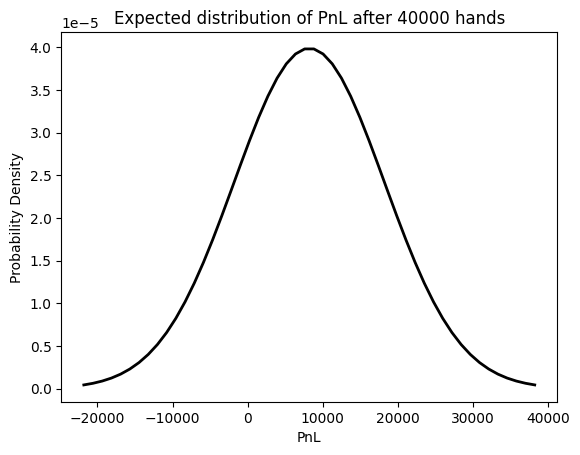

In [33]:
stake_bb = np.array([2,5,10])                  #stake_bb[i] represent the bb value for the ith stake
n_hands = np.array([10000,20000,10000])        #number of hands to be played at each stake
win_rates_100 = np.array([6,4,3])              #win rate per 100 hands corresponding to each stake. Values from 2 to 8 typical for pros.
sd_100 = np.array([100,100,100])               #sd per 100 hands corresponding to each stake. Values arround 100 typical for 6 handed nlh games.

#computing the values per hand
std_dev = std_dev_100*0.1                     #the sd scales with the square root of the number of hands
win_rates = win_rates_100*0.01                #the win rate per hand is .01 of the win rate per 100 hands

stake_mean = n_hands*stakes*win_rates         #computing the EVs per stake
total_mean = sum(stake_mean)                  #total EV in sample
print(f"EV: {total_mean:.2f}")

stake_sd = n_hands**.5*stakes*std_dev
total_sd = (np.sum(stake_std*stake_std))**.5                #sd of the total results across all stakes played
print(f"standard deviation of winnings: {total_sd:.2f}")
print(f"Sharpe Ratio: {total_mean/total_sd:.2f}")


mu, sigma = total_mean, total_std                           #Expected Normal distribution parameters

#confidence intervals for limiting Normal distribution
conf_70 = [-(norm.ppf(0.85))*sigma + mu, (norm.ppf(0.85))*sigma + mu]
conf_95 = [-(norm.ppf(0.975))*sigma + mu, (norm.ppf(0.975))*sigma + mu]
conf_99 = [-(norm.ppf(0.995))*sigma + mu, (norm.ppf(0.995))*sigma + mu]

print(f"70% confidence interval on winnings: [{conf_70[0]:.2f}, {conf_70[1]:.2f}]")
print(f"95% confidence interval on winnings: [{conf_95[0]:.2f}, {conf_95[1]:.2f}]")
print(f"99% confidence interval on winnings: [{conf_99[0]:.2f}, {conf_99[1]:.2f}]")

#Plotting the distribution
plt.xlabel('PnL')
plt.ylabel('Probability Density')
plt.title(f'Expected distribution of PnL after {sum(n_hands)} hands')

x = np.linspace(mu - 3*sigma, mu + 3*sigma)
y = norm.pdf(x, mu, sigma)                                  #Expected normal distribution

plt.plot(x, y, 'k', linewidth=2)

plt.show()

Simulating a bad beat jackpot (BBJ)

This next model allows the possibility of simulating a BBJ and computing it's effect on the variance and distribution of winnings. The default inputs for the BBJ payouts approximate the values found at GG poker and is assumed to be 0 EV. The effects of a BBJ are pretty massive; they double the standard deviation of the PnL, and are skewed right. 
Inputs are assumed to be in BB.

Justification for the Normal distribution assumption of hand results

The empirical wins and losses per hand are approximated from a sample of 600k I've played in a PokerTracker 4 database with the average win/loss normalized to 0. The empirical_sd of 10 Big Blinds per hand corresponds to 100 per 100 hands, which is approximately the average in 6-handed nlh games. After a few hundred hands, the limit Normal distribution with mu = empirical_mean and sigma = empirical_sd*sqrt(n_hands) closely approximates the simulated distribution of winnings.

True winrate and standard deviation per hand: 0.00, 10.05


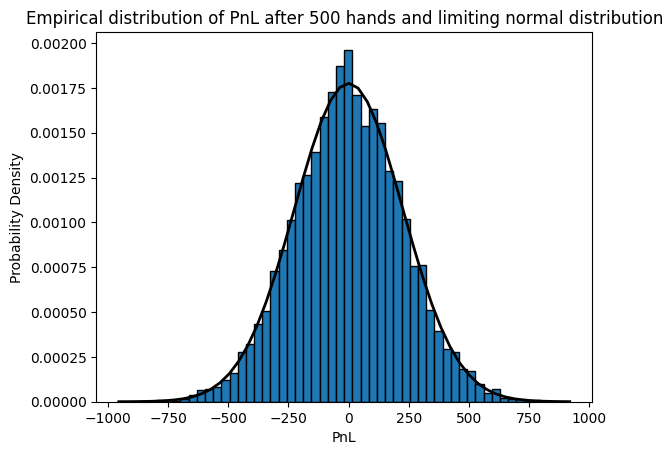

In [34]:
n_hands = 500                                                                          #number of hands to be simulated for each bootstrap batch
n_sims = 10000                                                                         #number of bootstrap batches, each with n_hands
win_loss = np.array([-100, -30, -10, -3, -1, 0, 1, 3, 10, 30, 100])                    #empirical win and loss sizes bb
win_loss_probs = 0.01*np.array([.35, 1.3, 3, 7, 16.5, 43.7, 16.5, 7, 3, 1.3, .35])     #empirical win/loss frequencies

#plt.hist(win_loss_probs, bins = win_loss, width=bin_width, edgecolor='black')
#plt.show()

def bootstrap(n_sims, n_hands):
    sims = []
    for i in range(n_sims):
        sim = np.random.choice(win_loss, size=n_hands, p=win_loss_probs)
        sims.append(sum(sim))
    return sims

#running n_sims iterations of the bootstrap, each simulating n_hands from the empirical win/loss distribution
sims = bootstrap(n_sims, n_hands)

#plotting a histogram of the simulated wins/losses in bb after n_hands
plt.hist(sims, bins=50, edgecolor='black', density = True)

# Plotting the results
plt.xlabel('PnL')
plt.ylabel('Probability Density')
plt.title(f'Empirical distribution of PnL after {n_hands} hands and limiting normal distribution')


empirical_mean, empirical_sd = weighted_avg_and_std(win_loss, win_loss_probs)    #True winrate and sd per hand, based on data provided
print(f"True winrate and standard deviation per hand: {empirical_mean:.2f}, {empirical_sd:.2f}")

mu, sigma = empirical_mean*n_hands, empirical_sd*n_hands**.5                        #Expected limiting distribution for samples of n_hands.

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)

#Limit normal distribution
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'k', linewidth=2)

plt.show()